# belief eye ICA, neural activity

rough version, get the plots ready for update first

### imports

In [37]:
%reload_ext autoreload
%autoreload 2

In [38]:
# import
from scipy.stats import pearsonr
import pickle
import os
import sys
from pathlib import Path
import tempfile
import pandas as pd
from cebra import CEBRA
import cebra
from scipy.stats import spearmanr, kendalltau
from sklearn.feature_selection import mutual_info_regression
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import FastICA
import torch
torch.cuda.is_available()

False

In [39]:
from pathlib import Path
datafile='0404normzica.nbedata'
# embeddingfile='0404normzica_0404.pt'
datanames=['m51s42','m51s38', 'm51s40', 'm51s41', 'm51s43']
datafiles=[]
for key in datanames:
    datafile=f'0506_{key}.nbedata'
    datafiles.append(Path(f'{workdir}/test/neural/cebra/{datafile}'))
datafiles

[PosixPath('/home/yc/repo/ffsb/test/neural/cebra/0506_m51s42.nbedata'),
 PosixPath('/home/yc/repo/ffsb/test/neural/cebra/0506_m51s38.nbedata'),
 PosixPath('/home/yc/repo/ffsb/test/neural/cebra/0506_m51s40.nbedata'),
 PosixPath('/home/yc/repo/ffsb/test/neural/cebra/0506_m51s41.nbedata'),
 PosixPath('/home/yc/repo/ffsb/test/neural/cebra/0506_m51s43.nbedata')]

In [40]:
try:
    config
except:
    import configparser
    config = configparser.ConfigParser()
    config.read_file(open('../../privateconfig'))
    resdir = Path(config['Datafolder']['data'])
    workdir = Path(config['Codefolder']['workspace'])
    os.chdir(workdir)


In [41]:
# my
from neural_plot_ult import *
from notification import notify

# ICA(taskvar-neural shared latent, taskvar)

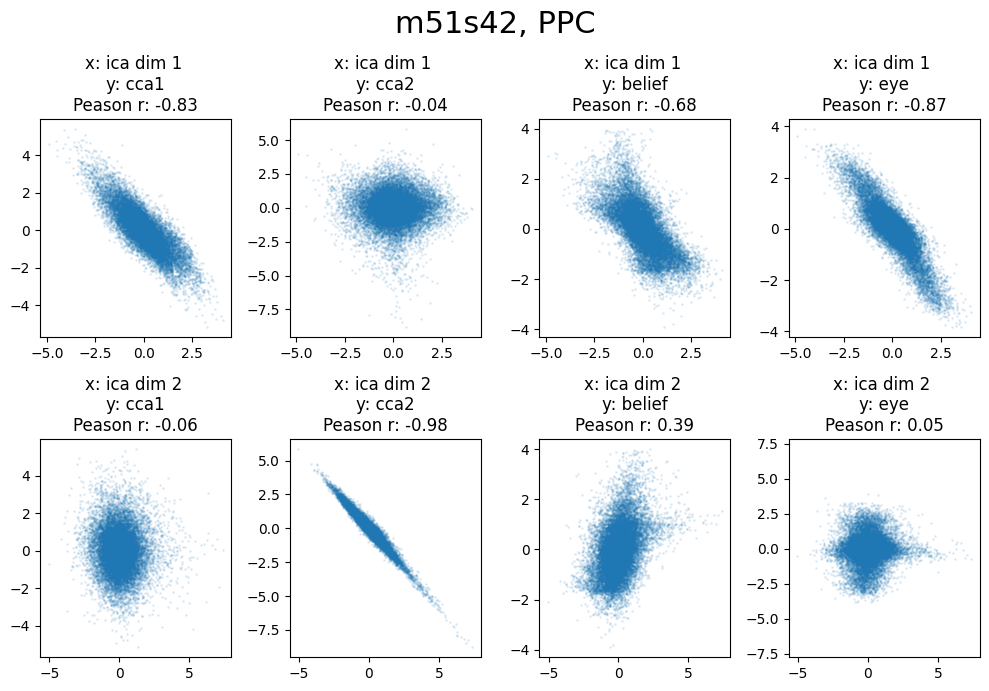

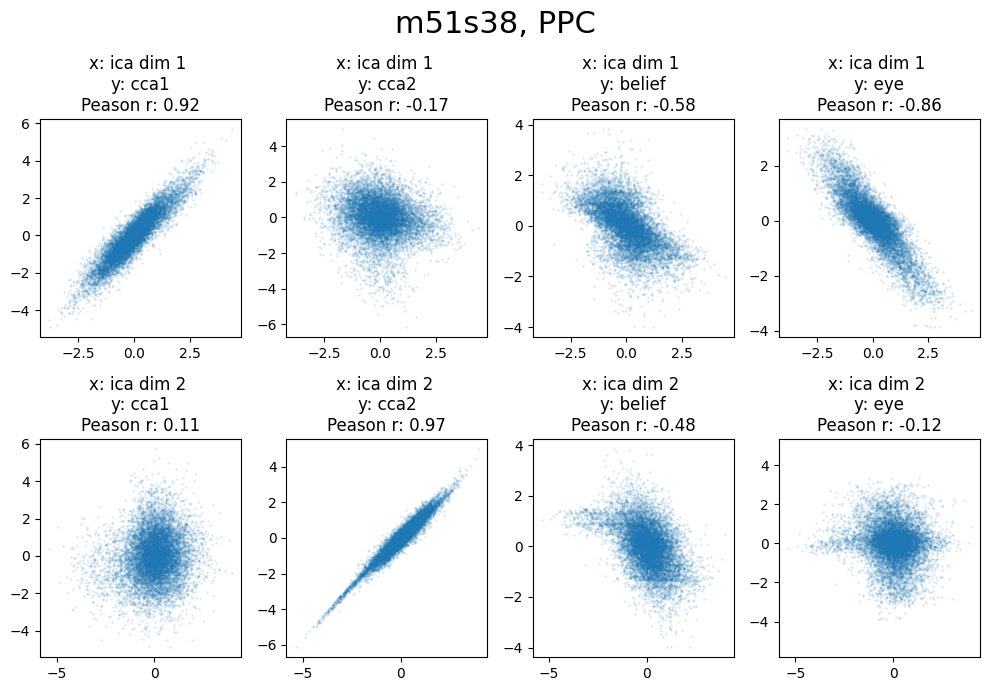

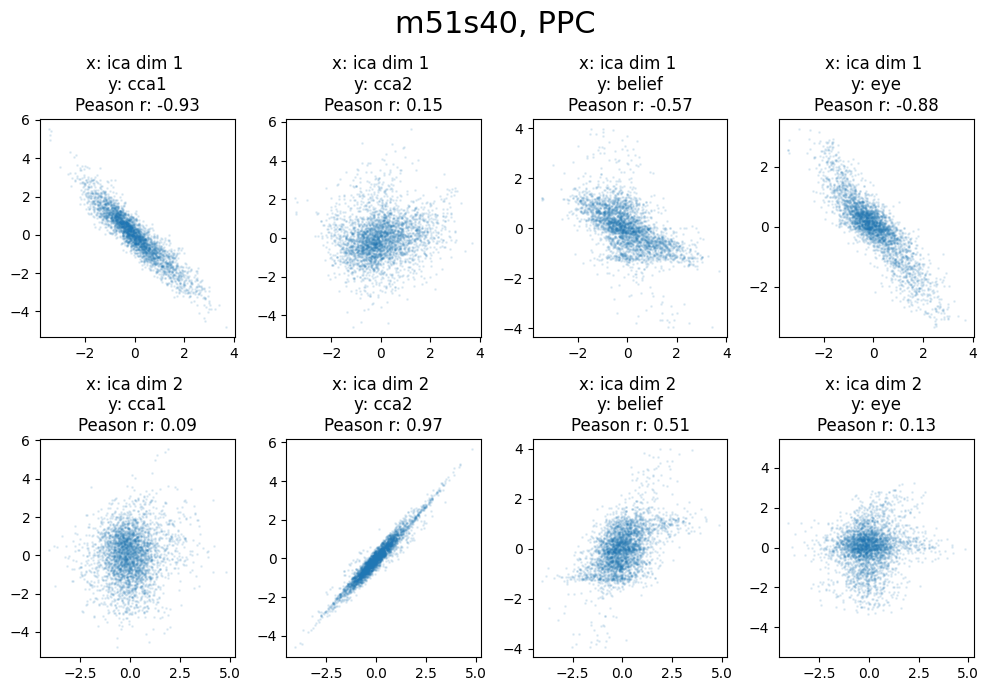

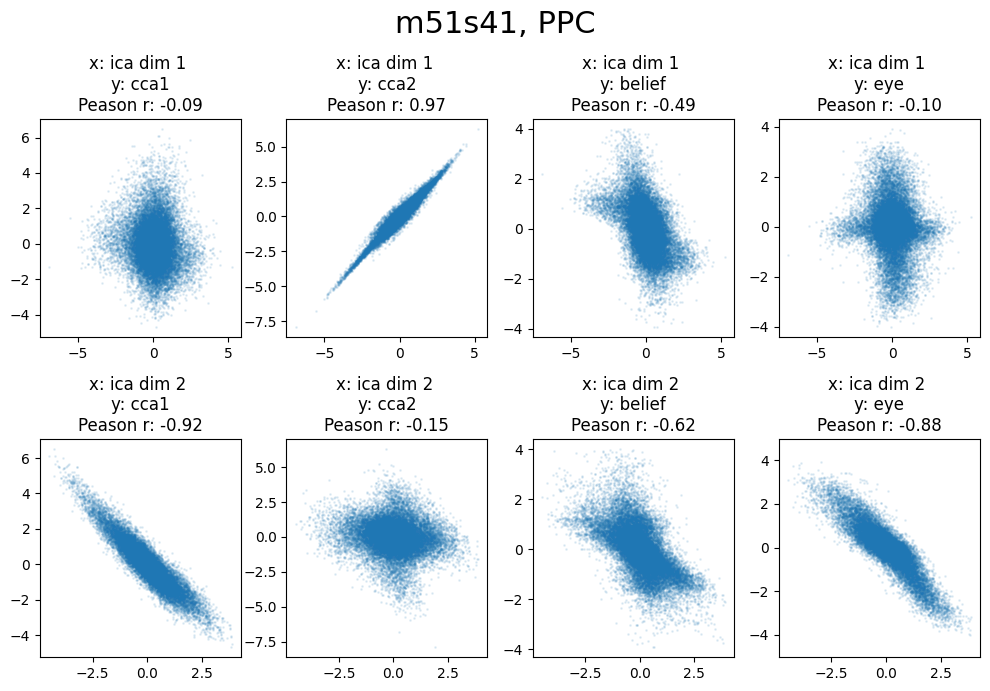

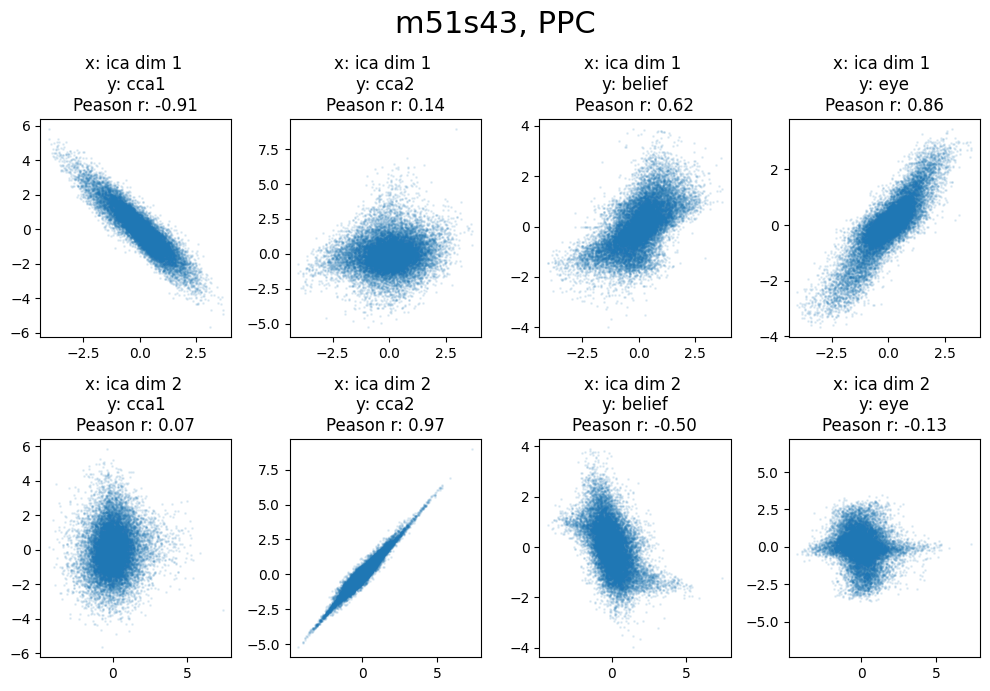

In [48]:
for datafile, dataname in zip(datafiles, datanames):
    with open(datafile, 'rb') as f:
        (neural_data, continuous_label, var_names) = pickle.load(f)
        
    (r_ppc_t,r_pfc_t,r_mst_t)=neural_data

    # ppc
    neural_data=r_ppc_t
    cca = CCA(n_components=2)
    related_taskvar=continuous_label[:,[4,2]]
    cca_neural, cca_be=cca.fit_transform(neural_data, related_taskvar)

    %matplotlib inline
    ica = FastICA(n_components=2)
    icaX=np.hstack([cca_neural,related_taskvar])
    icaS = ica.fit_transform(icaX) 

    varname=['cca1','cca2','belief', 'eye']
    fig, axs = plt.subplots(2,4, figsize=(10,7))
    for i in range(2):
        for j in range(4):
            ax=axs[i,j]
            ax.scatter(icaS[:,i],icaX[:,j], s=1, alpha=0.1)
            plt.axis('equal')
            r,_=pearsonr(icaS[:,i],icaX[:,j])
            ax.set_title(f'x: ica dim {i+1} \ny: {varname[j]}\nPeason r: {r:.2f}')
    plt.suptitle(f'{dataname}, PPC', fontsize=22)
    plt.tight_layout()
    plt.show()


In [63]:
for datafile, dataname in zip(datafiles, datanames):
        with open(datafile, 'rb') as f:
            (neural_data, continuous_label, var_names) = pickle.load(f)
        print(neural_data[2])
            

None
None
None
None
None


In [60]:
for datafile, dataname in zip(datafiles, datanames):
    try:
        with open(datafile, 'rb') as f:
            (neural_data, continuous_label, var_names) = pickle.load(f)
            
        (r_ppc_t,r_pfc_t,r_mst_t)=neural_data

        # ppc
        neural_data=r_pfc_t
        print(neural_data)
        cca = CCA(n_components=2)
        related_taskvar=continuous_label[:,[4,2]]
        cca_neural, cca_be=cca.fit_transform(neural_data, related_taskvar)

        %matplotlib inline
        ica = FastICA(n_components=2)
        icaX=np.hstack([cca_neural,related_taskvar])
        icaS = ica.fit_transform(icaX) 

        varname=['cca1','cca2','belief', 'eye']
        fig, axs = plt.subplots(2,4, figsize=(10,7))
        for i in range(2):
            for j in range(4):
                ax=axs[i,j]
                ax.scatter(icaS[:,i],icaX[:,j], s=1, alpha=0.1)
                plt.axis('equal')
                r,_=pearsonr(icaS[:,i],icaX[:,j])
                ax.set_title(f'x: ica dim {i+1} \ny: {varname[j]}\nPeason r: {r:.2f}')
        plt.suptitle(f'{dataname}, PFC', fontsize=22)
        plt.tight_layout()
        plt.show()
    except: continue


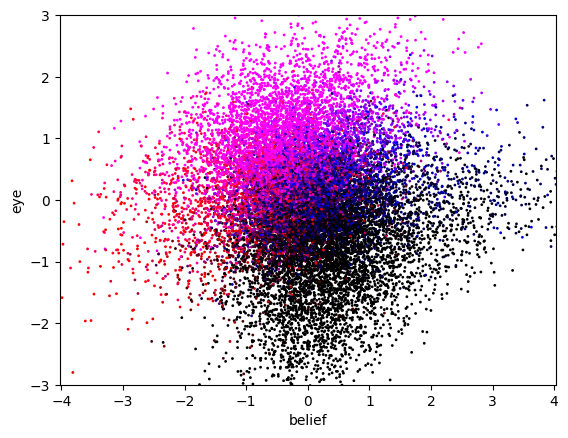

In [ ]:


ica = FastICA(n_components=2)
icaX=np.hstack([cca_neural,related_taskvar])
icaS = ica.fit_transform(icaX) 

thisx,thisy=icaS[:,0], icaS[:,1]
t1,t2=icaX[:,2],icaX[:,3]

c1=np.array([1,0,0])
c2=np.array([0,0,1])
rgb_values=np.zeros((len(t1), 3))
rgb_values[:,[0,2]]=0.3
# rgb_values.shape, c1.shape, t1.shape
rgb_values+=(c1[:, None]*t1).T
rgb_values+=(c2[:, None]*t2).T

rgb_values=(rgb_values)
rgb_values=rgb_values.clip(0,1)
hex_colors = [mcolors.rgb2hex(color) for color in rgb_values]
plt.scatter(thisx, thisy, c=hex_colors,s=1)
plt.xlabel('belief')
plt.ylabel('eye')
# plt.title('Scatter Plot with RGB Colors')
plt.axis('equal')
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.show()



## use raw neurons, cca only

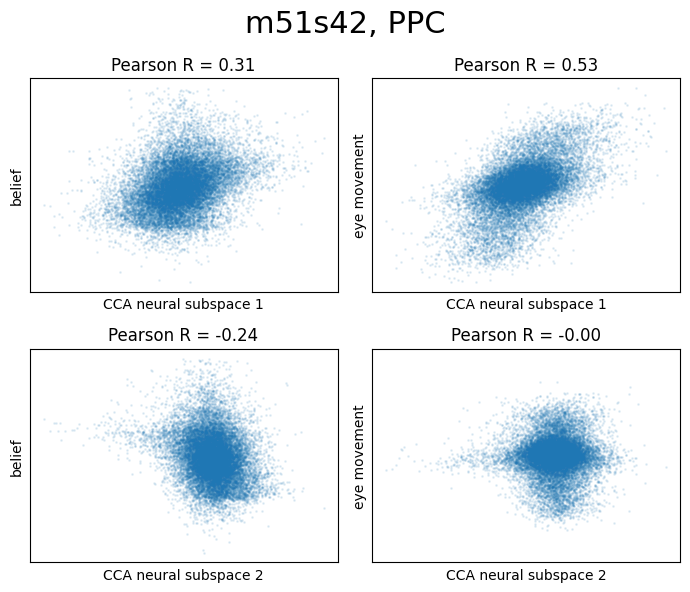

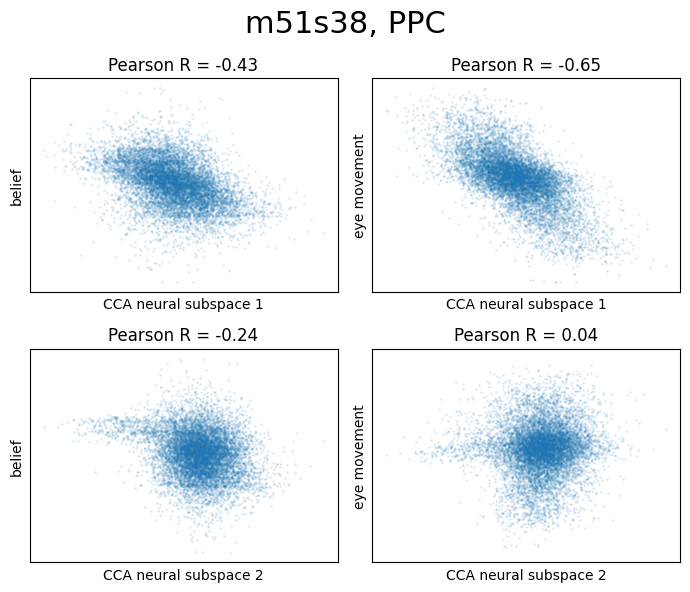

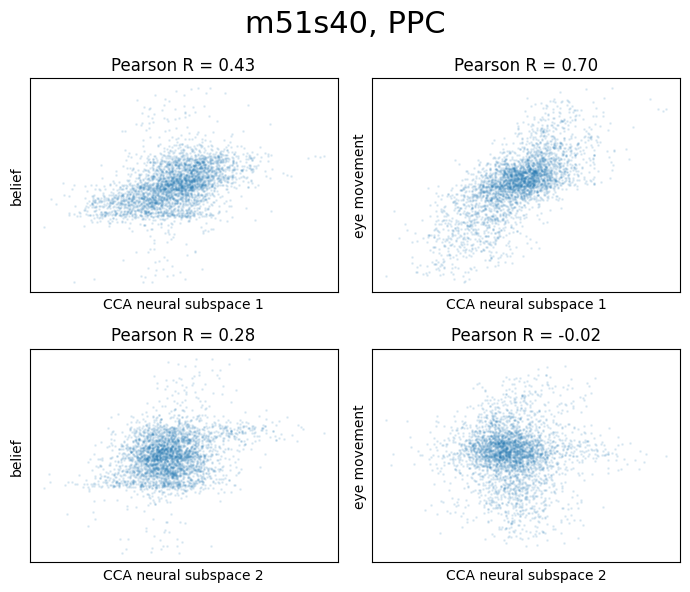

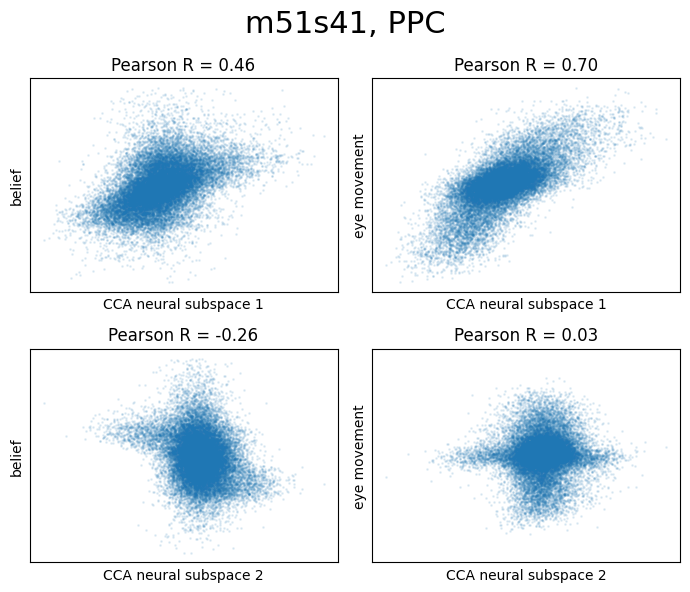

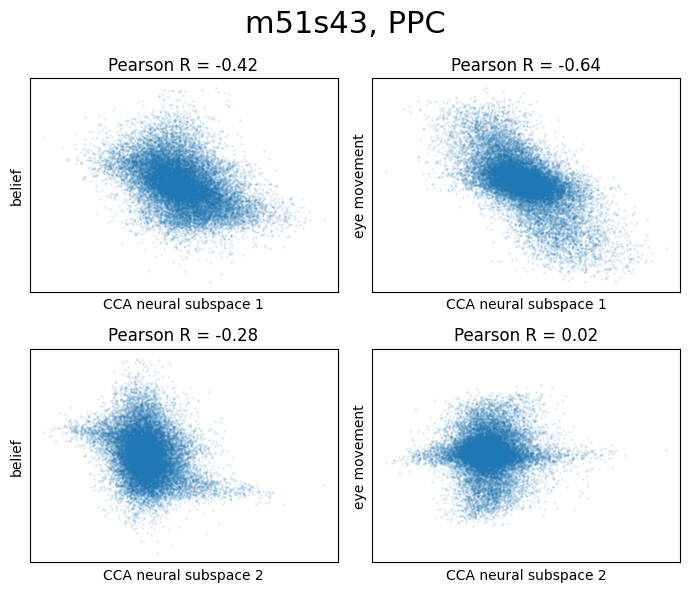

In [51]:
for datafile, dataname in zip(datafiles, datanames):
    with open(datafile, 'rb') as f:
        (neural_data, continuous_label, var_names) = pickle.load(f)
        
    (r_ppc_t,r_pfc_t,r_mst_t)=neural_data

    # ppc
    neural_data=r_ppc_t
    cca = CCA(n_components=2)
    related_taskvar=continuous_label[:,[4,2]]
    cca_neural, cca_be=cca.fit_transform(neural_data, related_taskvar)


    fig, axs = plt.subplots(2,2, figsize=(7,6))
    for i in range(2):
        for j,var in enumerate(['belief', 'eye movement']):
            ax=axs[i,j]
            ax.scatter(cca_neural[:,i],related_taskvar[:,j], s=1, alpha=0.1)
            plt.axis('equal')
            r=pearsonr(cca_neural[:,i],related_taskvar[:,j])[0]
            ax.set_title(f'Pearson R = {r:.2f}')
            ax.set_xlabel(f'CCA neural subspace {i+1}')
            ax.set_ylabel(f'{var}')
            ax.set_xticks([])
            ax.set_yticks([])

    plt.suptitle(f'{dataname}, PPC', fontsize=22)
    plt.tight_layout()
    plt.show()

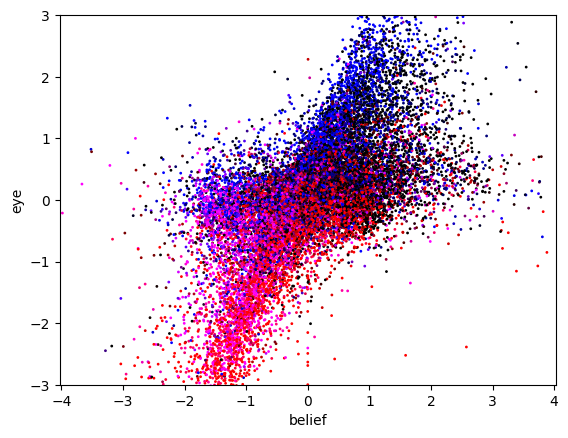

In [52]:

thisx,thisy=related_taskvar[:,0], related_taskvar[:,1]
t1,t2=cca_neural[:,0],cca_neural[:,1]

c1=np.array([1,0,0])
c2=np.array([0,0,1])
rgb_values=np.zeros((len(t1), 3))
rgb_values[:,[0,2]]=0.3
# rgb_values.shape, c1.shape, t1.shape
rgb_values+=(c1[:, None]*t1).T
rgb_values+=(c2[:, None]*t2).T

rgb_values=(rgb_values)
rgb_values=rgb_values.clip(0,1)
hex_colors = [mcolors.rgb2hex(color) for color in rgb_values]
plt.scatter(thisx, thisy, c=hex_colors,s=1)
plt.xlabel('belief')
plt.ylabel('eye')
# plt.title('Scatter Plot with RGB Colors')
plt.axis('equal')
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.show()



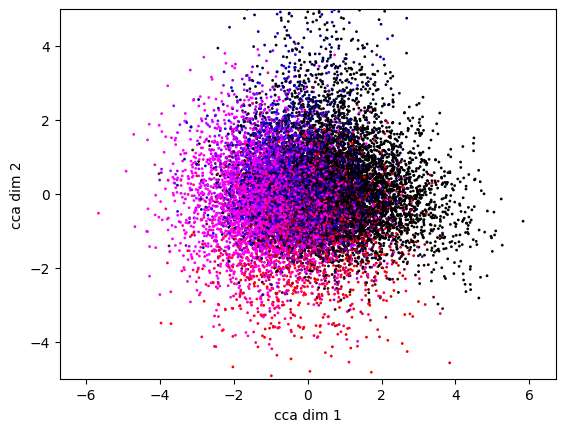

In [53]:

thisx,thisy=cca_neural[:,0],cca_neural[:,1]
t1,t2=related_taskvar[:,0], related_taskvar[:,1]
c1=np.array([1,0,0])
c2=np.array([0,0,1])
rgb_values=np.zeros((len(t1), 3))
rgb_values[:,[0,2]]=0.3
# rgb_values.shape, c1.shape, t1.shape
rgb_values+=(c1[:, None]*t1).T
rgb_values+=(c2[:, None]*t2).T

rgb_values=(rgb_values)
rgb_values=rgb_values.clip(0,1)
hex_colors = [mcolors.rgb2hex(color) for color in rgb_values]
plt.scatter(thisx, thisy, c=hex_colors,s=1)
plt.xlabel('cca dim 1')
plt.ylabel('cca dim 2')
# plt.title('Scatter Plot with RGB Colors')
plt.axis('equal')
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.show()

